# Spectrally-resolved Outgoing Longwave Radiation (OLR) with `RRTMG_LW`

In this notebook we will demonstrate how to use `climlab.radiation.RRTMG_LW` to investigate the clear-sky, longwave response of the atmosphere to perturbations in $CO_{2}$ and SST. In particular, we will use the new `return_spectral_olr` feature to explain the behaviour of the OLR to these changes.

Originally contributed by [Andrew Williams](https://github.com/AndrewWilliams3142)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp  #Gives access to the ODE integration package

## Set up idealized atmospheric profiles of temperature and humidity

In this example, we will use a temperature profile which is a moist adiabat, pegged to an isothermal stratosphere at $T_{strat}=200 \mathrm{K}$. We will also assume that relative humidity is fixed (a decent first-order assumption) at a constant value of $\mathrm{RH}=0.8$, with a profile given by [climlab.radiation.water_vapor.ManabeWaterVapor](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.water_vapor.html#climlab.radiation.water_vapor.ManabeWaterVapor).

In [2]:
from climlab.utils.thermo import pseudoadiabat

def generate_idealized_temp_profile(SST, plevs, Tstrat=200):
    """
    Generates an idealized temperature profile with specified SST and Tstrat
    """
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

def make_idealized_column(SST, num_lev=100, Tstrat=200):
    # Set up a column state
    state = climlab.column_state(num_lev=num_lev, num_lat=1)
    # Extract the pressure levels
    plevs = state['Tatm'].domain.axes['lev'].points
    # Set the SST
    state['Ts'][:] = SST
    # Set the atmospheric profile to be our idealized profile
    state['Tatm'][:] = generate_idealized_temp_profile(SST=SST, plevs=plevs, Tstrat=Tstrat)
    return state

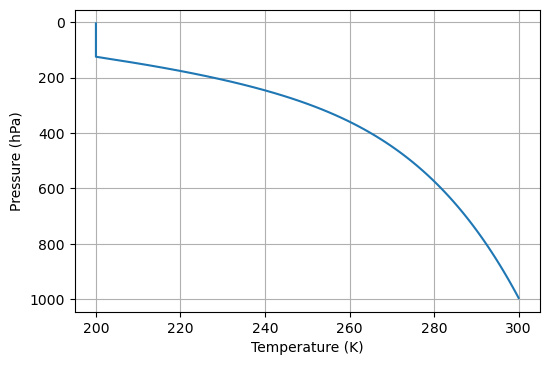

In [3]:
state = make_idealized_column(300)

# Plot the profile
fig, ax = plt.subplots(dpi=100)

state['Tatm'].to_xarray().plot(ax=ax, y='lev', yincrease=False)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (hPa)")
ax.grid()

Now, compute specific humidity profile using [climlab.radiation.water_vapor.ManabeWaterVapor](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.water_vapor.html#climlab.radiation.water_vapor.ManabeWaterVapor)

In [4]:
h2o = climlab.radiation.water_vapor.ManabeWaterVapor(state=state,
                                                     relative_humidity=0.8)

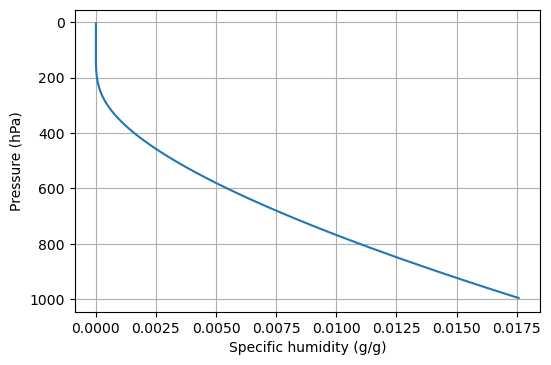

In [5]:
fig, ax = plt.subplots(dpi=100)

h2o.q.to_xarray().plot(ax=ax, y='lev', yincrease=False)

ax.set_xlabel("Specific humidity (g/g)")
ax.set_ylabel("Pressure (hPa)")
ax.grid()

## Run the profiles through `RRTMG_LW` 

With $CO_{2}=280\mathrm{ppmv}$ and all other radiatively active gases (aside from water vapour) set to zero.

In [6]:
absorber_vmr = {'CO2':280/1e6,
                'CH4':0.,
                'N2O':0.,
                'O2':0.,
                'CFC11':0.,
                'CFC12':0.,
                'CFC22':0.,
                'CCL4':0.,
                'O3':0.}

# RRTMG radiation
rad = climlab.radiation.RRTMG_LW(state=state, specific_humidity=h2o.q,  
                                 icld=0, # Clear-sky only!
                                 return_spectral_olr=False, # Just return total OLR
                                 absorber_vmr = absorber_vmr)

In [7]:
rad.compute_diagnostics()
rad.OLR

Field([301.06657198])

# Now, wrap it all into a simple function

This will make it easier to explore the behaviour of the OLR as a function of temperature and $CO_{2}$.

In [8]:
def calc_olr(SST, CO2ppmv, return_spectral_olr=False, RH=0.8, Tstrat=200, qStrat=5e-06):
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = make_idealized_column(SST, Tstrat=Tstrat)

    #  fixed relative humidity
    #  Note we pass the qStrat parameter here, which sets a minimum specific humidity
    #  Set RH=0. and qStrat=0. for fully dry column
    h2o = climlab.radiation.water_vapor.ManabeWaterVapor(state=state,
                                                         relative_humidity=RH,
                                                         qStrat=qStrat,
                                                        )
    
    absorber_vmr['CO2'] = CO2ppmv/1e6
    
    # RRTMG radiation
    rad = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=h2o.q,  
                                                   icld=0, # Clear-sky only!
                                                   return_spectral_olr=return_spectral_olr, 
                                                   absorber_vmr = absorber_vmr)
    rad.compute_diagnostics()
    
    return rad

In [9]:
# Test this gives the same as before...
calc_olr(SST=300, CO2ppmv=280).OLR

Field([301.06657198])

Now, lets iterate over a few `(SST, CO2)` pairs

In [10]:
%%time

n=20

OLRS = np.zeros((n,n))
temparray = np.linspace(280, 290, n)
co2array = np.linspace(280, 1200, n)

for idx1, temp in enumerate(temparray):
    for idx2, co2 in enumerate(co2array):
        OLRS[idx1, idx2] = calc_olr(temp, co2).OLR

CPU times: user 6.65 s, sys: 84.4 ms, total: 6.74 s
Wall time: 6.76 s


Text(0, 0.5, 'SST (K)')

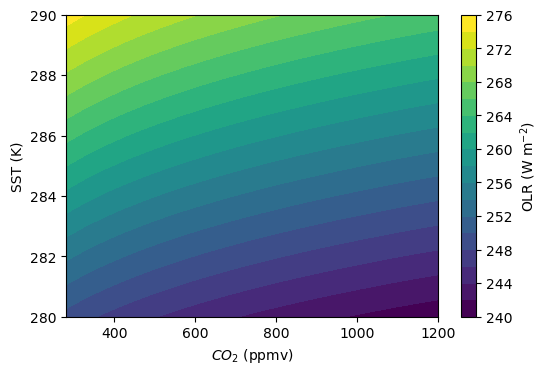

In [11]:
da = xr.DataArray(OLRS, dims=['temp', 'co2'], 
                  coords={'temp':temparray, 
                          'co2':co2array},
                 )

fig, ax = plt.subplots(dpi=100)

p = da.plot.contourf(ax=ax, 
                     cmap='viridis', 
                     levels=20,
                     add_colorbar=False)

fig.colorbar(p, label="OLR (W m$^{-2}$)")

ax.set_xlabel("$CO_{2}$ (ppmv)")
ax.set_ylabel("SST (K)")

### Okay then! As expected we can see that, all else being equal, increasing CO$_{2}$ <span style="color:blue">decreases the OLR</span>, whereas increasing the SST <span style="color:red">increases the OLR</span> in the model.

So then, what do these changes look like in `wavenumber` space? We can investigate this using the new `return_spectral_olr` argument to `RRTMG_LW`!

First though, let's check the model reproduces the Planck curve!

In [12]:
# To do this, we'll run the model with the idealized temperature profile
# but not include the effects of water vapour (i.e., set RH=0 and qStrat=0)

# We've already set all other absorbing species to 0.

rad1 = calc_olr(SST=300, CO2ppmv=0., RH=0., return_spectral_olr=True, qStrat=0.)

In [13]:
# check that the different OLRs match up...

print(rad1.OLR_spectral.to_xarray().sum('wavenumber').values)

print(rad1.OLR)

[454.81611717]
[454.87164075]


Now, lets check to see if we get the familiar Planck curve

In [14]:
wavenumbers = np.linspace(0.1, 3000) # don't start from zero to avoid divide by zero warnings

# Centers and Widths of the spectral bands, cm-1
spectral_centers = rad1.OLR_spectral.domain.axes['wavenumber'].points
spectral_widths = rad1.OLR_spectral.domain.axes['wavenumber'].delta

def planck_curve(wavenumber, T):
    '''Return the Planck curve in units of W/m2/cm-1
    Inputs: wavenumber in cm-1
            temperature T in units of K'''
    
    # 100pi factor converts from steradians/m to 1/cm
    return (climlab.utils.thermo.Planck_wavenumber(wavenumber, T)*100*np.pi) 

def make_planck_curve(ax, T, color='orange'):
    '''Plot the Planck curve (W/m2/cm-1) on the given ax object'''
    ax.plot(wavenumbers, planck_curve(wavenumbers, T),
            lw=2, color=color, label="Planck curve, {}K".format(T))
    
def make_planck_feedback(ax, T, color='orange'):
    '''Plot the Planck spectral feedback parameter (mW/m2/cm-1/K) on the given ax object'''
    ax.plot(wavenumbers, (planck_curve(wavenumbers, T+1)-planck_curve(wavenumbers, T))*1000,
            lw=2, color=color, label="Planck feedback, {}K".format(T))
    
def make_rrtmg_spectrum(ax, OLR_spectral, color='blue', alpha=0.5, label='RRTMG - 300K'):
    # Need to normalize RRTMG spectral outputs by width of each wavenumber band
    ax.bar(spectral_centers, np.squeeze(OLR_spectral)/spectral_widths, 
           width=spectral_widths, color=color, edgecolor='black', alpha=alpha, label=label)

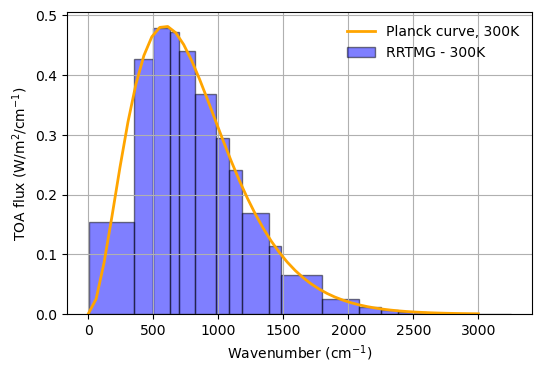

In [15]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100)

make_planck_curve(ax, 300, color='orange')
make_rrtmg_spectrum(ax, rad1.OLR_spectral, label='RRTMG - 300K')
ax.legend(frameon=False)

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")
ax.grid()

# Now, what happens when we include $CO_{2}$?

In [16]:
#  Same calculation as above but with some well-mixed CO2 in the column

rad2 = calc_olr(SST=300, CO2ppmv=10, RH=0., qStrat=0., return_spectral_olr=True, )
rad3 = calc_olr(SST=300, CO2ppmv=280, RH=0., qStrat=0., return_spectral_olr=True, )

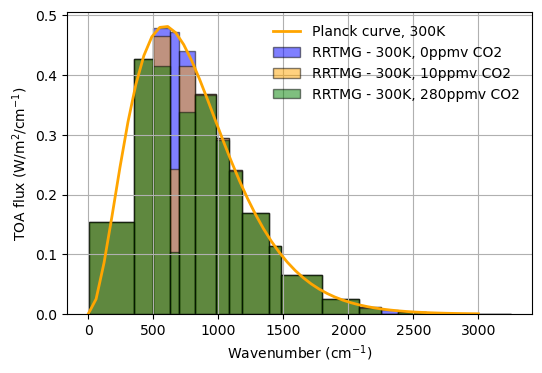

In [17]:
fig, ax = plt.subplots(dpi=100)

make_planck_curve(ax, 300, color='orange')
make_rrtmg_spectrum(ax, rad1.OLR_spectral, label='RRTMG - 300K, 0ppmv CO2', color='blue')
make_rrtmg_spectrum(ax, rad2.OLR_spectral, label='RRTMG - 300K, 10ppmv CO2', color='orange')
make_rrtmg_spectrum(ax, rad3.OLR_spectral, label='RRTMG - 300K, 280ppmv CO2', color='green')

ax.legend(frameon=False)

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")
ax.grid()

As we saw before, including $CO_{2}$ in the radiative transfer calculation reduces the total OLR (i.e., the spectral integral over what we've plotted). This happens predominantly due to absorption at the center of the $15 \mu\mathrm{m}$ $CO_{2}$ band (around $667.5 \mathrm{cm}^{-1}$). 

Note that increasing the $CO_{2}$ concentration causes a greater reduction at the center of the band, with increasing absorption at the edges (commonly referred to as the 'wings') of the band.

# What about water vapour?

Now, we'll redo the calculation, but include the specific humidity of water vapour in the call to `RRTMG_LW`.

In [18]:
# Our calc_olr() function handles water vapor by setting the RH parameter

rad4 = calc_olr(SST=300, CO2ppmv=0., RH=0.8, return_spectral_olr=True, )

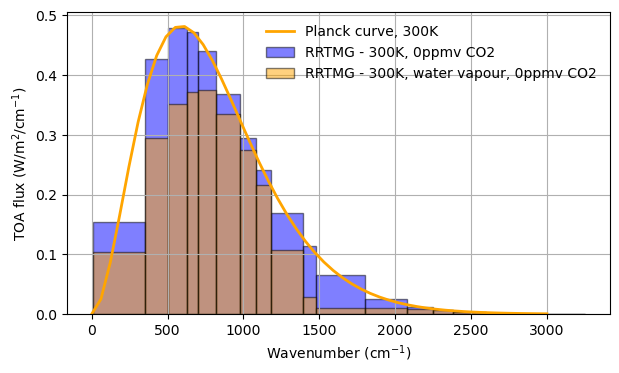

In [19]:
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

make_planck_curve(ax, 300, color='orange')
make_rrtmg_spectrum(ax, rad1.OLR_spectral, label="RRTMG - 300K, 0ppmv CO2", color='blue')
make_rrtmg_spectrum(ax, rad4.OLR_spectral, label="RRTMG - 300K, water vapour, 0ppmv CO2", color='orange')

ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")
ax.grid()

#### Water vapour clearly also influences the OLR spectrum quite a bit! Two interesting things to note:

Firstly, water vapour is a strong absorber at a much wider range of wavelengths than $CO_{2}$!

Secondly, there is a region around 800-1500 $\mathrm{cm}^{-1}$, where water vapour doesn't cause much absorption at all! This is the well-known water vapour *window*, and it is a region where warming can efficiently escape to space from the surface. The behaviour of these *window* region is extremely important in understanding the temperature dependence of Earth's OLR, and thus climate sensitivity (see, for example, Koll and Cronin (2018)). 

# $\textit{"Last call for orders! The water vapour window is closing!"}$

Clausius-Clapeyron tells us that the saturation water vapor pressure of water (i.e., the water-holding capacity of the atmosphere) increases by about 6-7% for every 1°C rise in temperature. One important consequence of this is that the optical depth of water vapour increases with temperature, which causes these spectral 'window' regions to eventually become optically thick. When this happens, the OLR in these regions becomes fixed and can't increase with warming. Can we see this in our model?

To do this, we'll run the model again at 280K, 300K and 320K, with a varying water vapour profile. We should see that the OLR in this window region eventually saturates to a constant value.

In [20]:
SSTcolors = {320: 'green',
             300: 'orange',
             280: 'blue',
            } 

rad = {}
for SST in SSTcolors:
    rad[SST] = calc_olr(SST=SST, CO2ppmv=0., RH=0.8, return_spectral_olr=True, )

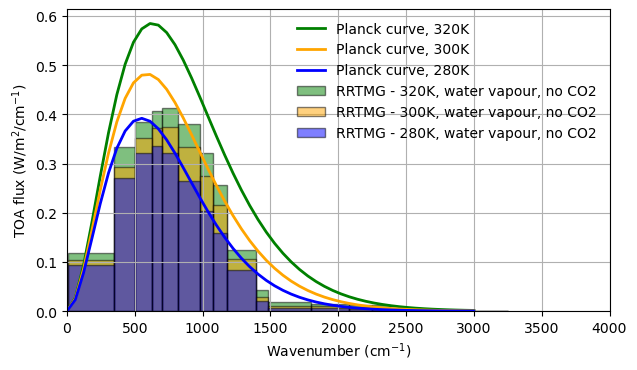

In [21]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

for SST in SSTcolors:
    make_planck_curve(ax, SST, color=SSTcolors[SST])
    make_rrtmg_spectrum(ax, rad[SST].OLR_spectral,
                        label="RRTMG - {}K, water vapour, no CO2".format(SST), 
                        color=SSTcolors[SST])

ax.set_xlim(0, 4000)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")
ax.grid()

# Nice!

We can clearly see from this plot that the OLR in the water vapour windows saturates between 300K and 320K

To make this more quantitative, lets consider the 'spectral' feedback parameter $\lambda_{\nu}$ for each SST, which is defined as the change in OLR per degree of warming, which we calculate as: 

$$\lambda_{\nu} = \frac{\mathrm{OLR}_{\nu}(\mathrm{SST}+1)- \mathrm{OLR}_{\nu}(\mathrm{SST})}{1\mathrm{K}}$$

Hence, because OLR eventually becomes decoupled from the SST at high enough temperatures, we should expect the feedback parameter to rapidly decline (eventually to zero) in these window regions.

In [27]:
feedback = {}
for SST in SSTcolors:    
    # Calculate perturbation (+1K) state diagnostics
    rad_p1 = calc_olr(SST=SST+1, CO2ppmv=0., RH=0.8, return_spectral_olr=True, )
    # Calculate spectral feedback parameter
    feedback[SST] = (rad_p1.OLR_spectral-rad[SST].OLR_spectral)

## At low temperatures, the feedback parameter in the window region is close the the Planck feedback, indicating efficient emission to space from these wavenumbers.

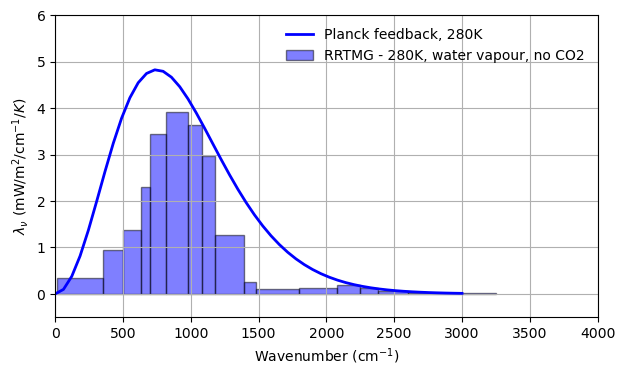

In [23]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

SST=280
make_planck_feedback(ax, SST, color=SSTcolors[SST])
make_rrtmg_spectrum(ax, feedback[SST]*1000,
                    label="RRTMG - {}K, water vapour, no CO2".format(SST), 
                    color=SSTcolors[SST])

ax.set_xlim(0, 4000)

ax.set_ylim(-0.5, 6)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel(r"$\lambda_{\nu}$ (mW/m$^{2}$/cm$^{-1}/K$)")
ax.grid()

### At higher temperatures, water vapour becomes optically thick in the window region, causing the OLR to become less sensitive to changes in surface temperature. As such, the feedback parameter reduces rapidly.

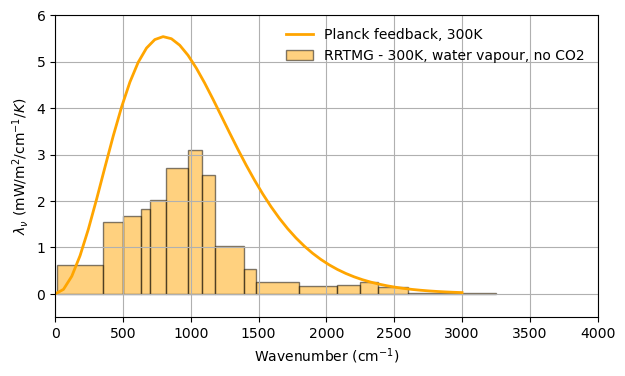

In [24]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

SST=300
make_planck_feedback(ax, SST, color=SSTcolors[SST])
make_rrtmg_spectrum(ax, feedback[SST]*1000,
                    label="RRTMG - {}K, water vapour, no CO2".format(SST), 
                    color=SSTcolors[SST])

ax.set_xlim(0, 4000)
ax.set_ylim(-0.5, 6)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel(r"$\lambda_{\nu}$ (mW/m$^{2}$/cm$^{-1}/K$)")
ax.grid()

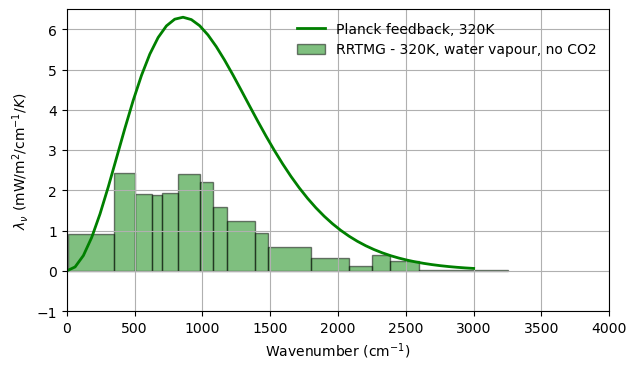

In [25]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

SST=320
make_planck_feedback(ax, SST, color=SSTcolors[SST])
make_rrtmg_spectrum(ax, feedback[SST]*1000,
                    label="RRTMG - {}K, water vapour, no CO2".format(SST), 
                    color=SSTcolors[SST])

ax.set_xlim(0, 4000)
ax.set_ylim(-1, 6.5)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel(r"$\lambda_{\nu}$ (mW/m$^{2}$/cm$^{-1}/K$)")
ax.grid()